In [1]:
import csv
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.misc import imread, imsave
import cv2
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import pickle
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [2]:
%matplotlib inline
sns.set_context("poster")

In [3]:
X_train = []
y_train = []

drives = ['driving_track_1_train_1.pkl',
         'driving_track_1_train_2.pkl',
         'driving_track_1_train_3.pkl',
         'driving_track_2_train_4.pkl',
         'driving_track_2_train_5.pkl',
         'driving_track_2_train_6.pkl']
for drive in drives:
    with open(drive, 'rb') as f:
        data = pickle.load(f)
    X_train.extend(data['images'])
    y_train.extend(data['steering_throttle'].astype(np.float64))
    X_train.extend(np.array([np.fliplr(x) for x in data['images']]))
    y_train.extend(np.negative(data['steering_throttle'].astype(np.float64)))
    
X_train = np.array(X_train)
y_train = np.array(y_train)[:,[0]]

In [4]:
print(X_train.shape, y_train.shape)

(112272, 80, 320, 3) (112272, 1)


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


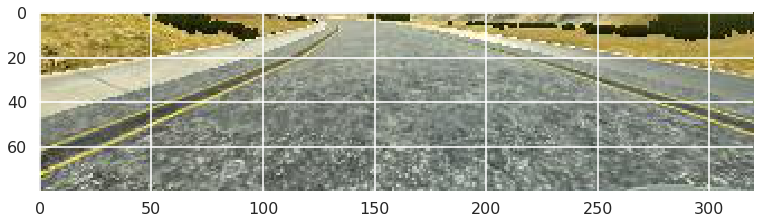

In [5]:
#view some images
plt.imshow(X_train[0])

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


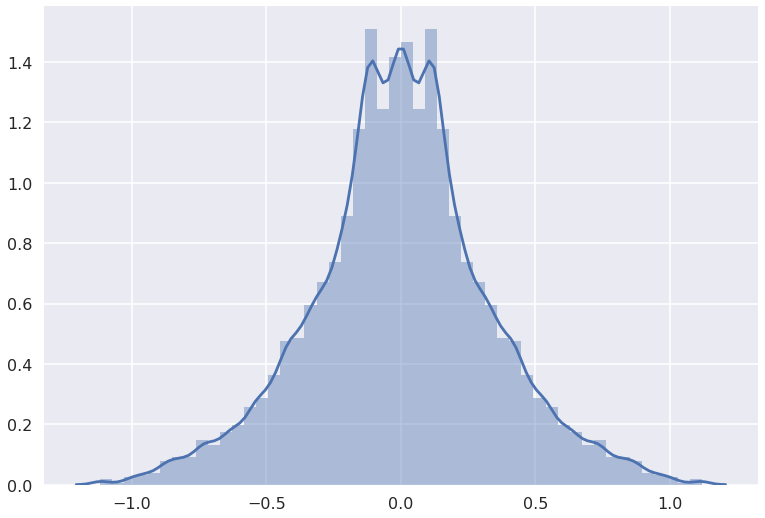

In [6]:
# now we need to evenly distribute the steering angles
# its likely there is an over bias towards straight
sns.distplot(y_train)

In [13]:
def create_model():
    model = Sequential()
    
    # preprocess
    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(80, 320, 3)))
    
    
    # conv1 layer
    model.add(Convolution2D(32, (5, 5)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('elu'))
    
    # conv2 layer
    model.add(Convolution2D(64, (5, 5)))
    model.add(MaxPooling2D((3, 3)))
    model.add(Activation('elu'))
    
    # conv3 layer
    model.add(Convolution2D(128, (3, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('elu'))

    # conv4 layer
    model.add(Convolution2D(128, (3, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('elu'))

    #add fully connected layers
    model.add(Flatten()) #Flatten input image
    
    # fc1
    model.add(Dense(1024))
    model.add(Dropout(0.5))
    model.add(Activation('elu'))
    
    # fc2
    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(Activation('elu'))
    
    # fc2
    model.add(Dense(64))
    model.add(Dropout(0.5))
    model.add(Activation('elu'))
    
    model.add(Dense(1)) #output layer with 1 regression value
    model.compile(loss="mse", optimizer="adam")

    return model

In [16]:
model = create_model()

In [ ]:
history = []
for i in range(30):
    h = model.fit(X_train, y_train, shuffle=True, epochs=3, validation_split=.2, batch_size=64)
    history.append(h)
    model.save("data_model_deeper{}.h5".format(i))
    

Train on 89817 samples, validate on 22455 samples
Epoch 1/3
89817/89817 [==============================] - 264s - loss: 0.0409 - val_loss: 0.0592
Epoch 2/3
89817/89817 [==============================] - 262s - loss: 0.0246 - val_loss: 0.0459
Epoch 3/3
89817/89817 [==============================] - 262s - loss: 0.0227 - val_loss: 0.0819
Train on 89817 samples, validate on 22455 samples
Epoch 1/3
89817/89817 [==============================] - 262s - loss: 0.0224 - val_loss: 0.1024
Epoch 2/3
89817/89817 [==============================] - 262s - loss: 0.0216 - val_loss: 0.1010
Epoch 3/3
89817/89817 [==============================] - 262s - loss: 0.0197 - val_loss: 0.0800
Train on 89817 samples, validate on 22455 samples
Epoch 1/3
89817/89817 [==============================] - 262s - loss: 0.0192 - val_loss: 0.0932
Epoch 2/3
89817/89817 [==============================] - 262s - loss: 0.0185 - val_loss: 0.0906
Epoch 3/3
89817/89817 [==============================] - 262s - loss: 0.0182 - val

In [ ]:
#loss: 0.0199 - val_loss: 0.0819